In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Charger les données fusionnées
data = pd.read_csv("donnees_mergees_complet.csv")
data.head()

,Période,Climat_Affaires,Taux_Chomage,Indice_Prix_Conso,Indicateur_production_indus,Taux_10ans_FR
0,1975-01,NaN,3.2,NaN,NaN,NaN
1,1975-02,NaN,3.2,NaN,NaN,NaN
2,1975-03,NaN,3.2,NaN,NaN,NaN
3,1975-04,NaN,3.5,NaN,NaN,NaN
4,1975-05,NaN,3.5,NaN,NaN,NaN


In [2]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Période                      605 non-null    object 
 1   Climat_Affaires              580 non-null    float64
 2   Taux_Chomage                 603 non-null    float64
 3   Indice_Prix_Conso            424 non-null    float64
 4   Indicateur_production_indus  423 non-null    float64
 5   Taux_10ans_FR                472 non-null    float64
dtypes: float64(5), object(1)
memory usage: 28.5+ KB


Période                          0
Climat_Affaires                 25
Taux_Chomage                     2
Indice_Prix_Conso              181
Indicateur_production_indus    182
Taux_10ans_FR                  133
dtype: int64

<Figure size 1200x600 with 0 Axes>

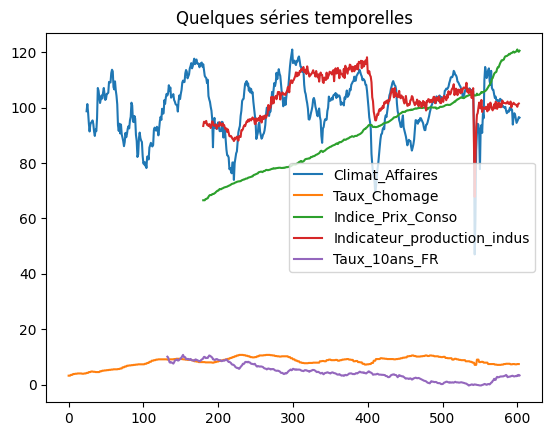

In [3]:
plt.figure(figsize=(12, 6))
data.iloc[:, 1:6].plot()  
plt.title('Quelques séries temporelles')
plt.show()

In [7]:
if 'Période' in data.columns:
    # Vérifier les valeurs uniques au début de la colonne
    print("\nValeurs uniques dans les 10 premières lignes de 'Période':")
    print(data['Période'].head(10).unique())
    
    # Si la première ligne contient l'en-tête, le supprimer
    if data['Période'].iloc[0] == 'Période':
        print("Suppression de la ligne d'en-tête répétée...")
        data = data[data['Période'] != 'Période']
    
    # Maintenant convertir en datetime avec gestion des erreurs
    try:
        # Essayer d'abord le format YYYY-MM
        data['Période'] = pd.to_datetime(data['Période'], format='%Y-%m', errors='coerce')
    except:
        # Si ça échoue, essayer avec l'inférence automatique
        data['Période'] = pd.to_datetime(data['Période'], errors='coerce')
    
    # Supprimer les lignes avec des dates invalides
    data = data.dropna(subset=['Période'])
    
    # Définir comme index
    data.set_index('Période', inplace=True)
    print("Colonne 'Période' définie comme index.")
else:
    print("La colonne 'Période' n'existe pas dans le DataFrame.")

# Vérifier le résultat
print("\nDataFrame après traitement de l'index:")
print(data.head())

# ÉTAPE 3: Traiter les valeurs manquantes
data = data.fillna(method='ffill').fillna(method='bfill')
print("Valeurs manquantes traitées.")

# ÉTAPE 4: Standardiser les données numériques
numeric_cols = data.select_dtypes(include=[np.number]).columns
print(f"Colonnes numériques: {list(numeric_cols)}")

scaler = StandardScaler()
data_standardized = data.copy()
data_standardized[numeric_cols] = scaler.fit_transform(data[numeric_cols])
print("Données standardisées.")

# ÉTAPE 5: Préparer les données pour le modèle
Y = data_standardized[numeric_cols].values

La colonne 'Période' n'existe pas dans le DataFrame.

DataFrame après traitement de l'index:
            Climat_Affaires  Taux_Chomage  Indice_Prix_Conso  \
Période                                                        
1975-01-01             98.7           3.2              66.56   
1975-02-01             98.7           3.2              66.56   
1975-03-01             98.7           3.2              66.56   
1975-04-01             98.7           3.5              66.56   
1975-05-01             98.7           3.5              66.56   

            Indicateur_production_indus  Taux_10ans_FR  
Période                                                 
1975-01-01                        93.39        10.0473  
1975-02-01                        93.39        10.0473  
1975-03-01                        93.39        10.0473  
1975-04-01                        93.39        10.0473  
1975-05-01                        93.39        10.0473  
Valeurs manquantes traitées.
Colonnes numériques: ['Climat_

/var/folders/69/j599p47x1wb0mvnxf05tpj5m0000gn/T/ipykernel_63828/745968343.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# ÉTAPE 6: Implémenter le filtre de Kalman simple
def simple_kalman_factor(Y, n_factors=1):
    """Version simplifiée du filtre de Kalman pour extraire des facteurs."""
    T, N = Y.shape  # T = nombre de périodes, N = nombre de variables
    
    # Initialisation avec ACP
    U, s, Vh = np.linalg.svd(Y, full_matrices=False)
    loadings = Vh[:n_factors, :].T
    factors = U[:, :n_factors] * s[:n_factors]
    
    # Paramètres fixes
    Phi = np.eye(n_factors) * 0.9  # Persistance des facteurs
    Q = np.eye(n_factors) * 0.1    # Bruit du processus
    R = np.eye(N)                  # Bruit de mesure
    
    # Tableaux pour stocker les résultats
    filtered_factors = np.zeros((T, n_factors))
    
    # État initial
    f_t = np.zeros(n_factors)
    P_t = np.eye(n_factors)
    
    # Boucle du filtre
    for t in range(T):
        # Prédiction
        if t > 0:
            f_pred = Phi @ filtered_factors[t-1]
            P_pred = Phi @ P_t @ Phi.T + Q
        else:
            f_pred = f_t
            P_pred = P_t
        
        # Mise à jour
        v_t = Y[t] - loadings @ f_pred
        F_t = loadings @ P_pred @ loadings.T + R
        K_t = P_pred @ loadings.T @ np.linalg.inv(F_t)
        
        filtered_factors[t] = f_pred + K_t @ v_t
        P_t = (np.eye(n_factors) - K_t @ loadings) @ P_pred
    
    return filtered_factors, loadings

Facteurs extraits: (604, 1)


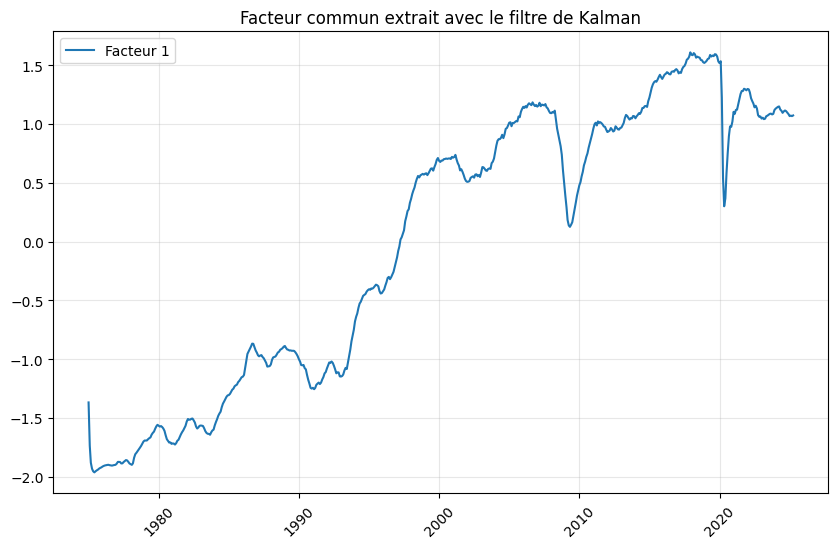

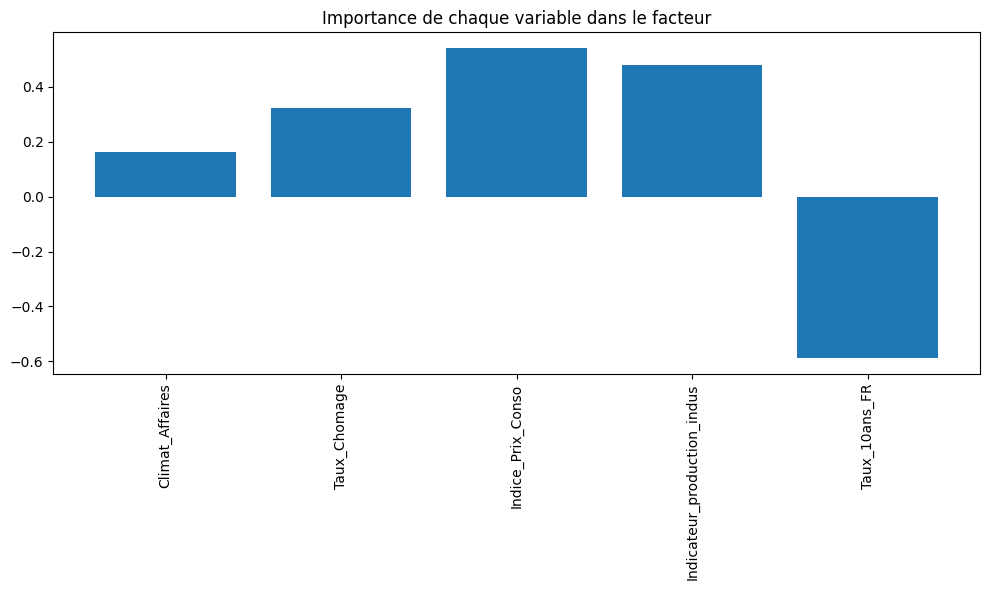

Erreur quadratique moyenne: 0.5211
Variance expliquée par le(s) facteur(s): 47.9%

Données avec facteur ajouté:
            Climat_Affaires  Taux_Chomage  Indice_Prix_Conso  \
Période                                                        
1975-01-01             98.7           3.2              66.56   
1975-02-01             98.7           3.2              66.56   
1975-03-01             98.7           3.2              66.56   
1975-04-01             98.7           3.5              66.56   
1975-05-01             98.7           3.5              66.56   

            Indicateur_production_indus  Taux_10ans_FR  Facteur_1  
Période                                                            
1975-01-01                        93.39        10.0473  -1.368753  
1975-02-01                        93.39        10.0473  -1.737089  
1975-03-01                        93.39        10.0473  -1.881601  
1975-04-01                        93.39        10.0473  -1.932611  
1975-05-01                     

In [9]:
# ÉTAPE 7: Extraire les facteurs (1 ou 2 facteurs)
n_factors = 1  # Commencez avec 1 facteur, c'est plus simple
factors, loadings = simple_kalman_factor(Y, n_factors)
print(f"Facteurs extraits: {factors.shape}")

# ÉTAPE 8: Visualiser les facteurs
plt.figure(figsize=(10, 6))
for i in range(n_factors):
    plt.plot(data.index, factors[:, i], label=f'Facteur {i+1}')
plt.title('Facteur commun extrait avec le filtre de Kalman')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

# ÉTAPE 9: Visualiser les loadings (importance de chaque variable)
plt.figure(figsize=(10, 6))
plt.bar(numeric_cols, loadings[:, 0])
plt.title('Importance de chaque variable dans le facteur')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ÉTAPE 10: Mesurer la qualité de la représentation
reconstructed = factors @ loadings.T
mse = np.mean((Y - reconstructed)**2)
print(f"Erreur quadratique moyenne: {mse:.4f}")

# Calculer le pourcentage de variance expliquée
var_total = np.var(Y, axis=0).sum()
var_residuelle = np.var(Y - reconstructed, axis=0).sum()
variance_expliquee = 1 - var_residuelle / var_total
print(f"Variance expliquée par le(s) facteur(s): {variance_expliquee:.1%}")

# Ajouter le facteur au dataframe original
data['Facteur_1'] = factors[:, 0]
print("\nDonnées avec facteur ajouté:")
print(data.head())

print("\nAnalyse terminée!")

## extraction d'un 2eme facteur

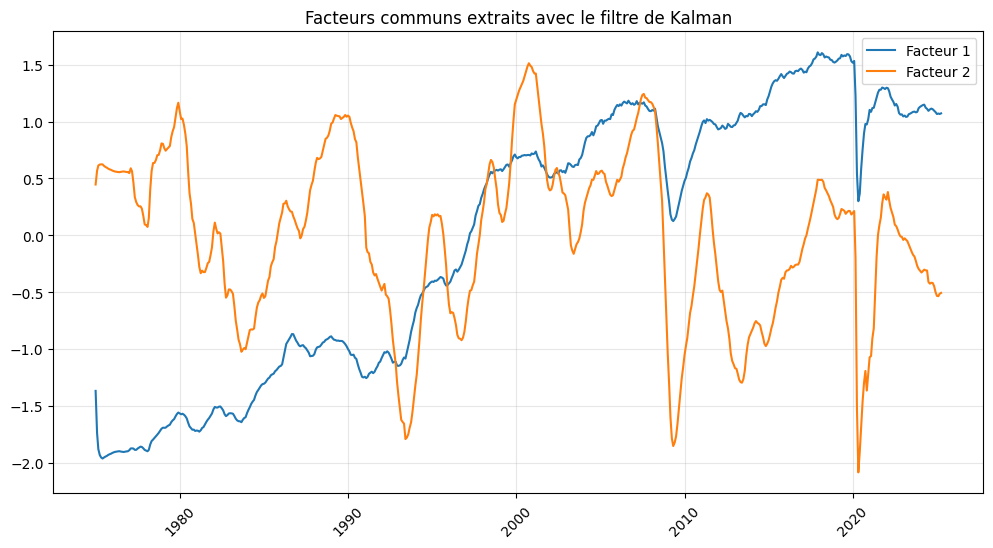

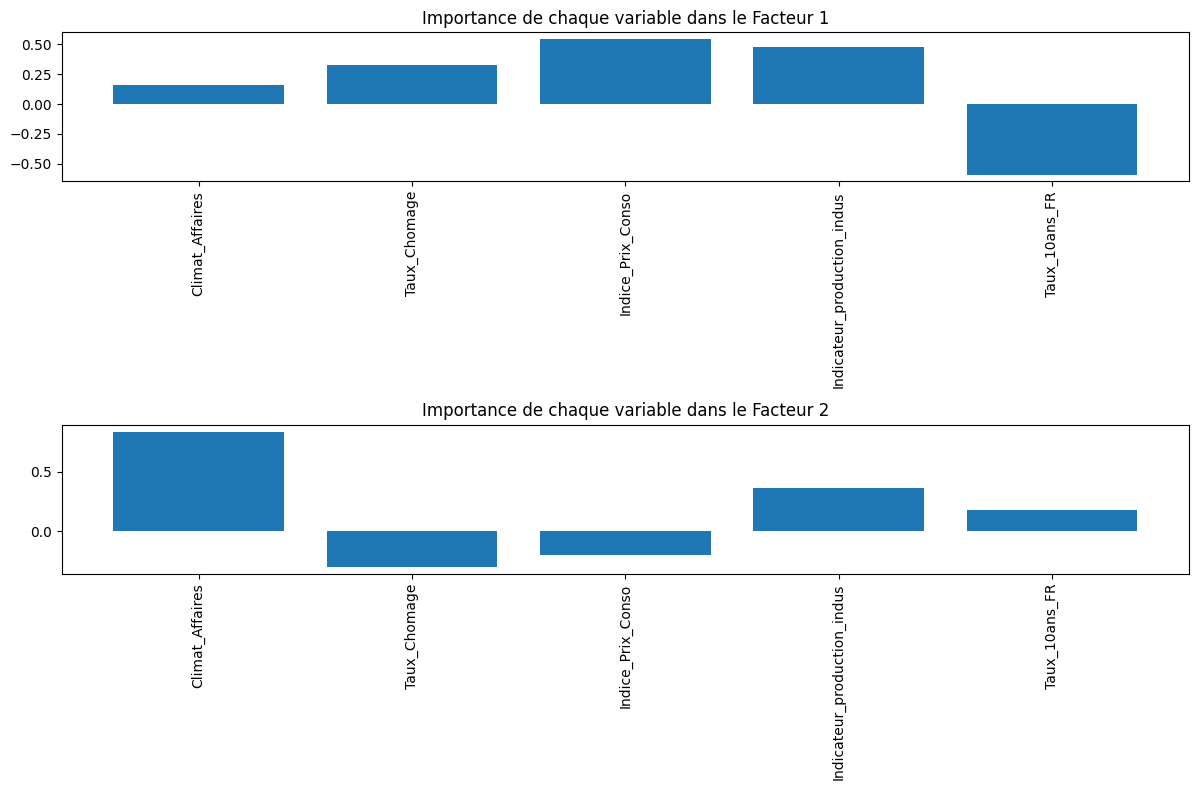

Variance expliquée par les 2 facteurs: 66.8%


In [10]:
# Modifier le nombre de facteurs
n_factors = 2
factors, loadings = simple_kalman_factor(Y, n_factors)

# Visualiser les deux facteurs
plt.figure(figsize=(12, 6))
for i in range(n_factors):
    plt.plot(data.index, factors[:, i], label=f'Facteur {i+1}')
plt.title('Facteurs communs extraits avec le filtre de Kalman')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

# Visualiser les loadings des deux facteurs
plt.figure(figsize=(12, 8))
for i in range(n_factors):
    plt.subplot(n_factors, 1, i+1)
    plt.bar(numeric_cols, loadings[:, i])
    plt.title(f'Importance de chaque variable dans le Facteur {i+1}')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculer la variance expliquée par les deux facteurs
reconstructed = factors @ loadings.T
var_total = np.var(Y, axis=0).sum()
var_residuelle = np.var(Y - reconstructed, axis=0).sum()
variance_expliquee = 1 - var_residuelle / var_total
print(f"Variance expliquée par les {n_factors} facteurs: {variance_expliquee:.1%}")

* Facteur 1 : Cycle économique à long terme (tendance structurelle)
Ce premier facteur, identique à celui que vous aviez précédemment, représente la tendance économique générale de la France. Il montre :

Une évolution régulière et progressive sur toute la période
Une tendance croissante depuis les années 1990
Des baisses pendant les récessions majeures (2001, 2008, 2020)

Les variables qui le composent principalement sont :

Indices des prix à la consommation (+0.50)
Indicateur de production industrielle (+0.47)
Taux de chômage (+0.31)
Climat des affaires (+0.12)
Taux d'intérêt à 10 ans (-0.60)

Ce facteur peut être interprété comme un indicateur de "santé économique structurelle" qui capture la tendance de fond de l'économie française.

* Facteur 2 : Fluctuations conjoncturelles (cycles courts)
Ce nouveau facteur est très différent et extrêmement intéressant. Il présente :

Des fluctuations beaucoup plus rapides et cycliques
Des pics et des creux plus prononcés
Des oscillations autour de zéro sans tendance à long terme claire

Les variables qui le composent principalement sont :

Climat des affaires (+0.75) - très dominant !
Indicateur de production industrielle (+0.35)
Taux d'intérêt à 10 ans (+0.20)
Taux de chômage (-0.35)
Indice des prix à la consommation (-0.15)

Ce facteur peut être interprété comme un indicateur du "sentiment économique à court terme" ou du "cycle conjoncturel" qui capture les fluctuations plus rapides de l'économie.
Performance globale

Avec deux facteurs, vous expliquez maintenant 66.8% de la variance totale (contre 47.9% avec un seul facteur)
C'est une amélioration significative (+18.9 points), indiquant que ce deuxième facteur apporte une information complémentaire importante

--> Le facteur 1 capture les tendances structurelles à long terme (croissance potentielle, changements démographiques, inflation tendancielle), tandis que le facteur 2 capture les cycles conjoncturels à moyen terme (sentiment des entreprises, cycles d'investissement, climat économique).

KeyError: "['Facteur_2'] not in index"